In [1]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict

In [2]:
%load_ext watermark
%watermark  -u -d -p numpy,pandas,matplotlib,sklearn

last updated: 2020-06-16 

numpy 1.18.2
pandas 1.0.3
matplotlib 3.2.1
sklearn 0.0


**NOTE** 코딩해야할 부분을 제외하고는 수정하지 마세요.

# DATA LOAD

In [3]:
mnist_sci = fetch_openml('mnist_784')

In [4]:
x_train, x_test, y_train_, y_test_ = train_test_split(mnist_sci.data, mnist_sci.target, 
                                                    test_size = 0.1,
                                                   shuffle = True)
x_train /= 255.0
x_test /= 255.0
x_train = x_train.reshape(-1,1,28,28)
x_test = x_test.reshape(-1,1,28,28)

def one_hoy_label(X):
    T = np.zeros((X.size, 10))    
    for idx, row in enumerate(T):
        row[int(X[idx])] = 1
        
    return T

y_train = one_hoy_label(y_train_)
y_test = one_hoy_label(y_test_)

In [5]:
class Softmax_CE:
    """
    편의를 위해서 softmax와 crossenropy를 결합한 것입니다.
    """
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = CE_loss(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

## 문제 1 에서 구현한 것을 바탕으로 CNN도 적용됩니다.

---

In [6]:
class Relu:
    ######################################################################
    # 문제 1-3 Rely layer 를 구현하세요                                  #
    # 출력값이 0이 되는 부분과 아닌 부분에 대해서 잘 생각해보세요        #
    ######################################################################
    
    # masking을 해보세요
    def __init__(self):
        self.mask = None     #mask는 T/F로 구성된 배열,
    

    def forward(self, x):
        
        self.mask = (x <= 0)     #mask는 x 원소값 <= 0 이면 True
        out = x.copy()           #                 그 외는 false
        out[self.mask] = 0
        
        return out
    
    # 항등항수의 미분은 자기 자신입니다. 
    def backward(self, dout):
        
        dout[self.mask] = 0 #mask가 True면 dout은 0 
        dx = dout

        return dx        #output 편미분값
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [7]:
class FClayer:
    ######################################################################
    # 문제 1-4 fully connecter layer 를 완성하세요                       #
    # 행렬의 곱셈에 대한 backward를 신중히 구현하세요                    #
    ######################################################################
    def __init__(self, W, b):
        
        self.W = W
        self.b = b
        
        self.x = None
        
        # backward 를 위해서 shape을 변경할 수가 있어서 원래의 shape 저장
        self.original_x_shape = None
        
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 본인이 구현한 입력 이미지의 shape 에 따라서 조정을 해줄수도 있습니다. 
        self.original_x_shape = x.shape
        
        x = x.reshape(x.shape[0], -1)
        
        self.x = x

        out = np.dot(self.x, self.W) + self.b  #우리가 기존에 알던 W.T * x와 x.T*W가 같다.
        # reshape을 x기준으로 진행했기 때문에 위와 같이 작성

        return out
    
    # 1차원 함수의 곱셈에 대해서 생각해보고 그것을 확장하세요 
    # 항상 데이터의 shape에 주의 하세요
    def backward(self, dout):      # 보고서에 이 부분 중요하게 작성 필요(매우 중요!!)

        dx = np.dot(dout, self.W.T)  
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape) # asterisk 사용함으로써 원래의 shape를 그대로 적용시키는 것 
                                                # (괄호 풀고 그대로 안으로 사용된다고 생각)
        
        return dx
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [8]:
def softmax(x):
    
    ######################################################################
    # 문제 1-1 softmax 함수를 구현하세요                                 #
    ######################################################################
    #y = np.array([])
    x = x.T
    x = x - np.max(x,axis=0) #softmax 함수에서는 그냥 x를 돌리면 지수함수로 결과가 있기 때문에
    #값이 많이 커져서 overflow문제가 생기게 된다. 따라서 x의 max값을 빼줘서 계산을 진행한다. softmax의 결과는 변하지 않는다.
    y = np.exp(x) / np.sum(np.exp(x),axis = 0)
    #print(x)
    #exp_x = np.exp(x)
    #exp_sum = np.sum(exp_x)
    
    #for a in exp_x:
    #    temp = a / exp_sum
    #    print(temp)
    #    y = np.append(y,temp)
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################
    
    return y.T 

In [9]:
def CE_loss(y, t):
    
    ######################################################################
    # 문제 1-2 cross entropy 함수를 구현하세요.                               
    # y 값의 경우 예측한 값, t값의 경우 true label 값입니다.    
    # batch 로 데이터가 들어온다는 것을 유의 하세요.
    ######################################################################
    if y.ndim == 1:    #1차원일 경우
        t = t.reshape(1, t.size)   #1차원 배열로 원래는 ( , n) 꼴이므로
        y = y.reshape(1, y.size)
        
    # train 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    # 어차피 곱할것이므로 0인 값은 버리는 느낌으로 1일 때의 값으로 반환한다는 말
    if t.size == y.size:
        t = t.argmax(axis=1) 
             
    batch_size = y.shape[0]    #다 적용 한것을 average해야 하므로 batch size로 나눠줘야 하므로 batch size 구함
    return -np.sum(np.log10(y[np.arange(batch_size), t])) / batch_size  #cross entropy의 정의에 따른 수식
    

    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [10]:
class Conv():
    def __init__(self, W, b, stride=1, pad=0
    ):
        super().__init__()
        
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None   
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None
        
        self.out_h = None
        self.out_w = None
        
    
    def forward(self, x):
        # backward 의 shape 확인을 위해서 저장
        self.x = x[:]        
        
        FN, C_, FH, FW = self.W.shape # 필터 수, 필터 채널 수, 필터 행 수, 필터 열 수  
        N, C, H, W = x.shape # 인풋 갯수, 인풋 채널 수, 필터 행 수, 필터 열 수
        
        # output 출력 shape 
        self.out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        self.out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        out_h = self.out_h
        out_w = self.out_w        
        
        # padding
        pad_x = np.pad(
            x, 
            ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), # 3차원 패딩, 2차원 패딩(col), 1차원 패팅(row)
            "constant", constant_values=0
        )
        
        
        #print(FN , C_ , FH , FW , N , C , H, W , out_h, out_w)
        #FN = 3  C_ = 1 FH = 3  FW = 3  N =100  C = 1 H = 28 W = 28 out_h = 26 out_w =26
        
        out = np.zeros((N, FN, out_h, out_w))       

        for n in range(N): # input 갯수
            for f in range(FN): # 필터 갯수
                for j in range(out_h): # 세로 크기 
                    for i in range(out_w): # 가로 크기
                        ######################################################################
                        # 문제 2-1-1 forward를 구현 하세요                                   #
                        ######################################################################
                       # N = 100, FN = 3, out_h = 26, out_w = 26
                        #필터를 컨볼루션(값들을 곱해서 더해서 가운데 픽셀로 값을 정함)
                        out[ n , f , j ,i] = np.sum(pad_x[ n , : ,  j * self.stride : j * self.stride + FH, i * self.stride : i * self.stride + FW] * \
                                                    self.W[ f , : , : , : ], \
                                                    axis =  (0,1,2)) \
                                                    + self.b[f]
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
        return out

    def backward(self, dout):
        
        FN, C, FH, FW = self.W.shape
        N, C, H, W = self.x.shape
        
        out_h = self.out_h
        out_w = self.out_w
        
        # padding
        pad_x = np.pad(
            self.x, 
            ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), 
            "constant", constant_values=0
        )
        
        dx = np.zeros(pad_x.shape)
        dw = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)
        
    
        for n in range(N):
            for f in range(FN):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-1-2 backward 구현 하세요                                   #
                        ######################################################################
                        # DNN처럼 dx에서는 편미분에 따라 dout과 W.T를 곱했던것 dw도 마찬가지 db는 마찬가지로 열을 합하는것
                        dx[n, : , j * self.stride : j * self.stride + FH, i * self.stride : i * self.stride + FW]  += self.W[f,:,:,:] * dout[n, f, j//self.stride, i//self.stride]
                        dw[f,:,:,:] += pad_x[n, : , j*self.stride : j*self.stride + FH, i * self.stride : i * self.stride + FW ] * dout[n, f, j, i]
                        db[f] = np.sum(dout[:, f , : , : ])
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
                        
        # remove padding
        dx = dx[:, :, self.pad:dx.shape[2]-self.pad, self.pad:dx.shape[3]-self.pad]
      
        self.db = db
        self.dW = dw
        
        return dx

In [11]:
class MaxPooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
    
    def forward(self, x):
        self.x = x[:]
        N, C, H, W = x.shape
        
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        
        out = np.zeros((N, C, out_h, out_w))
        
        
        for j in range(out_h):
            for i in range(out_w):
                ######################################################################
                # 문제 2-2-1 forward를 구현 하세요                                   #
                ######################################################################
                #max pooling 값들의 max값을 뽑아야 하므로 np.max사용 axis는 2,3 필터 행렬의 max값 
                val1 = np.max(self.x[:,:,j*self.stride:j*self.stride+self.pool_h, i*self.stride:i*self.stride+self.pool_w],axis =(2,3))
                #val2 = np.amax(self.x[:,:,j*self.stride:j*self.stride+self.pool_h, i*self.stride:i*self.stride+self.pool_w])
                    
                        
                out[:,:,j,i] = val1
                ######################################################################
                #                          END OF YOUR CODE                          #
                ######################################################################
        return out

    def backward(self, dout):
        
        N, C, H, W = self.x.shape
        out_h = (H-self.pool_h) // self.stride + 1
        out_w = (W-self.pool_w) // self.stride + 1

        dx = np.zeros(self.x.shape)
        for n in range(N):
            for c in range(C):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-2-2 backward를 구현 하세요                                   #
                        ######################################################################
                        #backward는 pooling을 하는 것에 masking을 도입 -> relu와 비슷하게 접근했음
                        x_pool = self.x[n, c, j * self.stride : j * self.stride + self.pool_h, i * self.stride : i * self.stride + self.pool_w]
                       
                        mask = (x_pool == np.max(x_pool) )   
                 
                        dx[n, c, j * self.stride : j * self.stride + self.pool_h, i * self.stride : i * self.stride + self.pool_w] =  mask * dout[n, c, j, i]
                    
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################        
        
        return dx

In [12]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        weight_init_std = 0.01
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = MaxPooling(pool_h=2, pool_w=2, stride=2)
        self.layers['FClayer1'] = FClayer(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['FClayer2'] = FClayer(self.params['W3'], self.params['b3'])

        self.last_layer = Softmax_CE()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        ######################################################################
        #  2-3 해당 주어진 gradient 함수에 주석을 다세요                     #
        ######################################################################
        # forward
        self.loss(x, t) #cross entropy함수 적용

        # backward
        dout = 1     #dout 1로 시작 -> cross entropy는 target값이 그대로 나오기 때문에 
                     #1 곱하기 어떤 값과 0곱하기 나머지 값이므로 1로 초기화 필수!!
        dout = self.last_layer.backward(dout)         #가장 최근 layer는 softmax와 cross entropy
        #이 코드로 cross entropy와 softmax의 backward 진행

        layers = list(self.layers.values())  #list로서 layer의 values만 뽑아서 저장
        layers.reverse()   #gradient 함수 자체는 진행방향이 거꾸로 되어 있기 때문에 reverse로 바꿔주도록 한다.
        
        for layer in layers:    #layer value 반복
            dout = layer.backward(dout)   #dout을 최종 단계 까지 backward 진행
            ## 여기서 dout을 layer를 지날 때 마다 값을 갱신해주면서 dout은 새로운 layer의 input dout으로 들어가게 된다.
            ##layer의 정의된 backward 함수를 지날 때 마다 또 다른 dout이 나오게 되는 과정을 반복

        # 결과 저장
        grads = {}
        ###grads는 return값이므로 해당하는 각 layer의 gradient값들을 계산해야한다.
        # convolution의 첫 번째 단계의 gradient값들 저장
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db    
        # Fully connected layer 첫 번째의 gradient값 저장
        grads['W2'], grads['b2'] = self.layers['FClayer1'].dW, self.layers['FClayer1'].db 
        # Fully connected layer 두 번째의 gradient 값 저장
        grads['W3'], grads['b3'] = self.layers['FClayer2'].dW, self.layers['FClayer2'].db 

        return grads

In [13]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 3, 'filter_size': 3, 'pad': 0, 'stride': 1},
                        hidden_size=16, output_size=10)

In [14]:
def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

## 학습이 되기전 conv layer 의 파라미터값

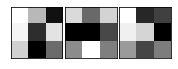

In [15]:
filter_show(network.params['W1'])

In [16]:
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1
cnt = 0
test_acc_list = []
epochs = 3
step = int(train_size / batch_size)

for epoch in range(epochs):
    for batch_idx in range(step):
        cnt = cnt + 1 
        print(cnt)  ##컴퓨터의 성능이 좋지 않아 시간이 오래 걸려서 진척 상황을 보기 위한 코드 입니다... 
        x_batch = x_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        y_batch = y_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        grad = network.gradient(x_batch, y_batch)


        # 매개변수 갱신
        for key in network.params.keys():
            network.params[key] -= learning_rate * grad[key]

        # 학습 경과 기록
        loss = network.loss(x_batch, y_batch)

    test_acc = network.accuracy(x_test, y_test)
    print(" test acc | " + str(test_acc))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
 test acc | 0.922


## 학습 후 파라미터 값

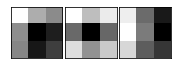

In [17]:
######################################################################
#  2-4 학습된 필터를 캡처하여 제출하세요                                      #
######################################################################
filter_show(network.params['W1'])